# Предсказание погоды с использованием временных рядов.
Задача: строить прогнозы погоды на основе исторических метеорологических данных.

## Загрузка датасета

In [ ]:
# Импорт библиотек
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Выгрузка данных из таблицы с тренировочными данными
train_data: np.ndarray = pd.read_csv("CSV/DailyDelhiClimateTrain.csv").values

# Выгрузка данных из таблицы с тестовыми данными
test_data: np.ndarray = pd.read_csv("CSV/DailyDelhiClimateTest.csv").values

print(train_data)

[['2013-01-01' 10.0 84.5 0.0 1015.6666666666666]
 ['2013-01-02' 7.4 92.0 2.98 1017.8]
 ['2013-01-03' 7.166666666666667 87.0 4.633333333333334
  1018.6666666666666]
 ...
 ['2016-12-30' 14.095238095238097 89.66666666666667 6.266666666666667
  1017.904761904762]
 ['2016-12-31' 15.052631578947368 87.0 7.325 1016.1]
 ['2017-01-01' 10.0 100.0 0.0 1016.0]]


## Нормализация данных

Естественно, ни одна модель не сможет понять, что значит строковое представление даты "2017-01-01",  
так что давайте приведем значения первого столбца к целым числам (кол-во дней с начала отсчета)

Функция перевода даты в кол-во дней от 2013-01-01 (самая первая дата в таблице):

In [1]:
def days_since_zero_date(date_str: str) -> int:
	# Преобразование строки в объект datetime
	date_format: str = "%Y-%m-%d"
	date_obj = datetime.strptime(date_str, date_format)
	
	# Нулевая дата
	zero_date = datetime.strptime("2013-01-01", date_format)
	
	# Вычисление разницы в днях
	delta = date_obj - zero_date
	days = delta.days
	 
	return days

Теперь переведем все даты в загруженных таблицах в дни и выведем результат:

In [2]:
# Применяем ранее определенную функцию ко всем датам датасета
train_data[:, 0] = np.vectorize(days_since_zero_date)(train_data[:, 0])
test_data[:, 0] = np.vectorize(days_since_zero_date)(test_data[:, 0])

train_data = train_data.astype("float")
test_data = test_data.astype("float")

print(train_data[0])
# Вывод - [0 10.0 84.5 0.0 1015.6666666666666]
# Видно, что все даты превратились в дни

NameError: name 'np' is not defined

Далее необходимо нормализовать данные. Нормализовывать данные будем по методу Z-Нормализации. 

![Z-normalize](assets/Z-normalize.png)

Где:  
  
- **X с чертой** - среднее значение выборки

- **Сигма {x}** - стандартное отклонение выборки

- **x{i}** - ненормализованное значение

- **x{i}'** - нормализованное значение

In [ ]:
class Normalize:
	def __init__(self, data: np.ndarray) -> None:
		self.data: np.ndarray = np.copy(data) # Записываем копию данных
		
		# Вычисляем среднее по каждому столбцу
		self.__mean: np.ndarray = data.mean(axis=0)
		# Вычисляем стандартное отклонение по каждому столбцу
		self.__std_dev: np.ndarray = data.std(axis=0)
		
	def normalizeData(self) -> np.ndarray:
		# Возврат нормализованных даннах по формуле
		return (self.data - self.__mean) / self.__std_dev
		
	def DeNormalizeData(
		self, normalized_data: np.ndarray, axes: list[int] = [0, 1, 2, 3]
	) -> np.ndarray:
		# Денормализация днанных по указанной оси
		return normalized_data * self.__std_dev[axes] + self.__mean[axes]

# Нормализация погодных данных
train_normalize_class = Normalize(train_data[:, 1:])
train_data[:, 1:] = train_normalize_class.normalizeData()

В данном фрагменте был создан класс, реализующий логику нормализации данных. 
В двух последних строках нормализовали обучающую выборку (кроме значений дней).
Метод DeNormalizeData позволяет интерпретировать любые данные, полученные с помощью модели, в привычной нам форме.

Построим график температуры для наглядности.

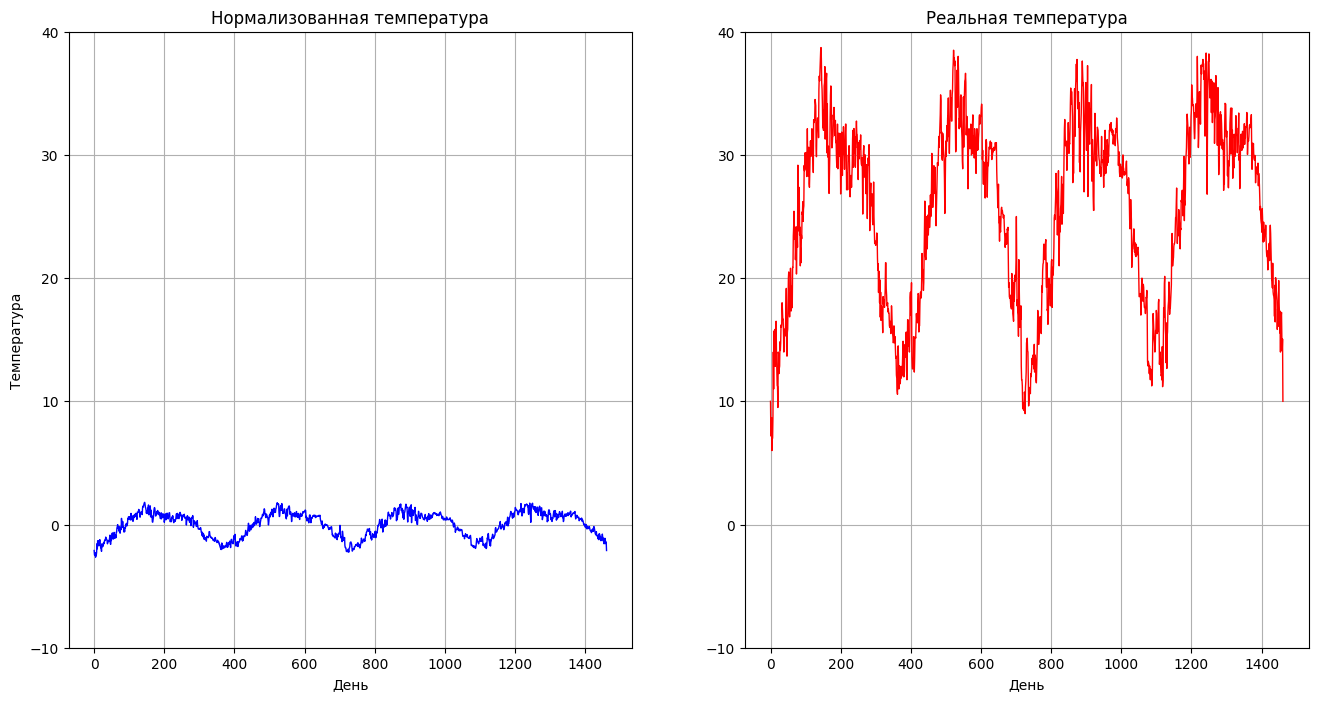

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Лимиты для осей
ax[0].set_ylim([-10, 40])
ax[1].set_ylim([-10, 40])

# Подписи осей
ax[0].set_ylabel("Температура")
ax[0].set_xlabel("День")
ax[1].set_xlabel("День")

ax[0].set_title("Нормализованная температура")
ax[1].set_title("Реальная температура")

# Сетка на осях
ax[0].grid()
ax[1].grid()

# Отображение нормализованных и ненормализованных данных на примере температуры
ax[0].plot(train_data[:, 1], c='b', linewidth=1)
ax[1].plot(
    train_normalize_class.DeNormalizeData(train_data[:, 1], axes=0),
    c='r',
    linewidth=1
)

plt.show()

Поскольку наша нейронная сеть имеет в своих нейронах значения, обозначающие вероятность,  
нам необходима нормализация данных для ограничения входного значения между (-1..1).  
Такие данные будут более удобны для анализа нейронной сетью

## Сглаживание шума

Сглаживать шум будем методом скользящей средней. Суть метода в том, что мы проходимся по всему графику "окном" определенного размера. Перемещая окно, вычисляем среднее всех значений, которые в него попали. Таким образом мы сглаживаем весь шум графика, так как он компенсирует сам себя. 

![SMA](assets/SMA.png)

**SMA{t}** - значение простого скользящего среднего в точке **t**  
  
**n** - количество значений исходной функции для расчёта скользящего среднего (размер "окна")  
  
**p{t-i}** - значение исходной функции в точке **t-i**

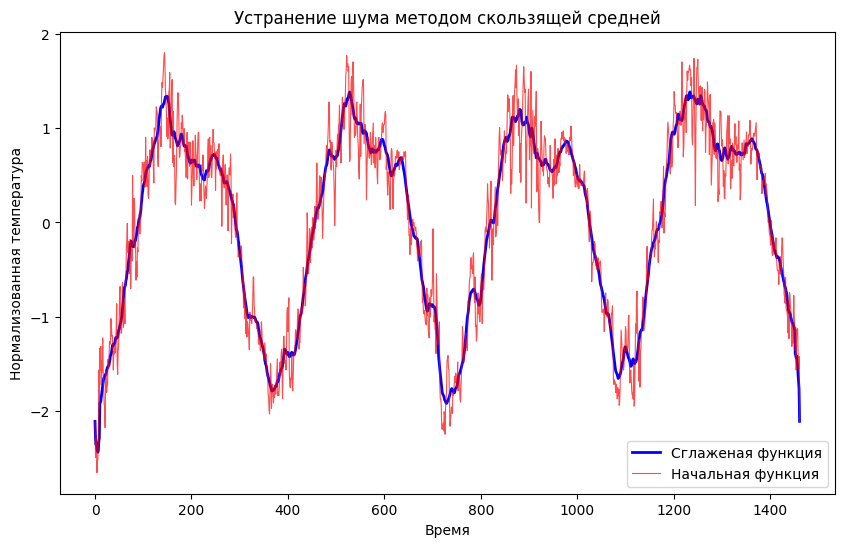

In [ ]:
def SMA(data, window=30):
	sma_values = np.zeros_like(data)
	l = window // 2
	r = (window + 1) // 2
	for i in range(data.shape[0]):
		if i < l:
			sma_values[i] = np.mean(data[:i + 1])
		elif i < data.shape[0] - r:
			sma_values[i] = np.mean(data[i - l: i + r])
		else:
			# Здесь чтобы количество данных SMA совпадало с количеством данных по температуре 
			# SMA суммируются под конец с все меньшим и меньшим окном
			sma_values[i] = np.mean(data[i:])
	return sma_values

window_size = train_data.shape[0] // 70
denoised_data = SMA(pd.Series(train_data[:, 1]), window_size)

fig = plt.figure(figsize=(10, 6))
plt.plot(denoised_data, label="Сглаженая функция", c='b', linewidth=2.0)
plt.plot(train_data[:, 1], label="Начальная функция", c='r', alpha=0.7, linewidth=0.8)

plt.title("Устранение шума методом скользящей средней")
plt.ylabel("Нормализованная температура")
plt.xlabel("Время")
plt.legend()

plt.show()

## Прогнозирование данных

Видно, что график температуры обладает ярко выраженной периодичностью и сильно напоминает синусоиду.
Из этого вытекает цель - подобрать наиболее подходящую синусоиду (или сумму синусоид), которая будет наилучшим образом соответствовать температуре.

Подбор подходящей кривой с помощью преобразования Фурье и градиентного спуска.

### Подбор подходящей кривой с помощью преобразования Фурье и градиентного спуска.

Преобразование Фурье - операция, которая сопоставляет первой функции вторую: вторая функция описывает коэффициенты («амплитуды») при разложении первой функции на элементарные составляющие — гармонические колебания с разными частотами. То есть фактически данное преобразование раскладывает функцию на сумму синусов разной частоты.

Формально преобразование определяется так:

![furry](assets/furry.png)

Таким образом, если мы возьмем несколько синусоид максимальной амплитуды (те, которые лучше всего аппроксимируют наши данные) и построим график их суммы, то мы получим неплохую аппроксимацию температуры (в нашем случае).

Но, к сожалению, преобразование Фурье не выдает нам все веса идеальной функции, но и нам нужна только частота, ведь остальные параметры мы получим с помощью метода градиентного спуска.

In [3]:
# Значения на оси X (абсциссе), на основе которых модель будет делать предсказания
x_data: np.ndarray = np.linspace(0, len(denoised_data), len(denoised_data))

# Дискретное Преобразование Фурье, список амплитуд
mfft: np.ndarray = np.fft.fft(denoised_data)

# Получаем индексы частот, которые соответствуют самым значимым (с высокой амплитудой) синусоидам.
imax: np.ndarray = np.argsort(np.absolute(mfft))[::-1]


NameError: name 'np' is not defined

Для простоты мы будем раскладывать наши данные на сумму 5 синусоид.  
Не будем брать слишком много слагаемых, чтобы модель не потеряла обобщающую способность.

In [ ]:
# Кол-во синусов, которые мы будем суммировать
number_of_sinuses: int = 5

# Берем первые number_of_sinuses самых высоких амплитуд (они соответствуют частотам)
imax = imax[:number_of_sinuses]

# Вычисляем частоту каждой синусоиды
frequency:np.ndarray = np.array(imax) / len(denoised_data)

print(frequency)

[2.73597811e-03 9.97264022e-01 5.47195622e-03 9.94528044e-01
 6.83994528e-04]


### Оптимизация параметров
Для начала определим функцию, которая будет аппроксимировать наши данные о температуре.  
Из-за того, что мы рассматриваем сумму 5 синусов:

![sinus_sum](assets/sinus_sum.png)

Теперь нужно инициализировать наши параметры так, чтобы их получилось верно оптимизировать (большинство моделей плохо оптимизируют параметры тригонометрических функций со случайно инициализированной частотой).

1. Параметр **w{3i}** будем инициализировать значением стандартного отклонения всей выборки (**w{3i}** = **Сигма {x}**).
  
2. Параметр **w{3i+1}** (самый важный) будем инициализировать полученной частотой (умноженной на **2\pi**) для каждого синуса соответственно (**w{3i+1}** = **2\pi * f{i}**). Это нужно сделать, чтобы модель не подбирала частоту волны, в противном случае параметры не будут оптимизированы.
  
3. Параметр сдвига по абсциссе мы инициализируем **-np.pi/2**
  
4. Параметр b мы инициализируем математическим ожиданием выборки (**b** = **X с чертой**)

In [ ]:
# Начальные параметры
init_paams: np.ndarray = np.array(
	[
		np.array([np.std(denoised_data), frequency[i] * 2 * np.pi, -np.pi/2])
		for i in range(number_of_sinuses)
	]
)

bias: float = np.mean(denoised_data)


array([[9.69585817e-01, 1.71906575e-02, 0.00000000e+00],
       [9.69585817e-01, 6.26599465e+00, 0.00000000e+00],
       [9.69585817e-01, 3.43813150e-02, 0.00000000e+00],
       [9.69585817e-01, 6.24880399e+00, 0.00000000e+00],
       [9.69585817e-01, 4.29766437e-03, 0.00000000e+00]])

### Функция ошибки (MSE)

В качестве функции ошибки модели используем функция ошибки MSE, которую наш алгоритм будет пытаться минимизировать  
  
![MSE](assets/MSE.png)  

Где:
    
- **y** - реальное значение целевой переменной (метка)  
  
- **y с чертой** - предсказание модели



### Градиентный спуск
Градиентный спуск заключается в том, что по мере обучения модели мы вычитаем из каждого веса значение его локальной частной производной от функции ошибки.  
Данный алгоритм приводит к ее минимизации, то есть к наиболее точным ответам модели.  
  
![gradient](assets/gradient.png)  
  
Где:  
  
- **E** - функция ошибки
  
- **w{n}** - данный вес
  
- **η** - коэффициент скорости обучения (чем больше, тем агрессивнее обучается модель, часто выбирают 10^{-3})

Поскольку нам сразу известна формула, по которой будет проходить апроксимация данных, нам будет очень полезно найти формулы градиентов по каждому из весов:  
Общая формула градиента:
  
![gradient_general](assets/gradient_general.png)  
  
1. Градиент по амплитуде **ω{3i}**
  
![​gradient_formula1](assets/gradient_formula1.png)  
  
2. Градиент по частоте **ω{3i+1}**  
  
![​gradient_formula2](assets/​gradient_formula2.png)  
​  
3. Градиент по фазе **ω{3i+2}**   
  
![​gradient_formula3](assets/​gradient_formula3.png)  
  
4. Градиент по смещению **b**  
  
![​gradient_formula4](assets/​gradient_formula4.png)

### Оптимизатор Adam

Оптимизируем наши параметры путем градиентного спуска в связке с оптимизатором Adam.  
Идея Adam заключается в том, чтобы адаптивно изменять скорость обучения для каждого веса на основе двух моментов первого и второго порядков градиента.  
Веса с большим градиентом получают меньший шаг, а веса с меньшим градиентом получают больший шаг.  
  
Оптимизатор работает по данному алгоритму:  
  
![ADAM_elements](assets/ADAM_elements.png)
  
Оптимизация весов:  
  
![ADAM](assets/ADAM.png)  
  
Где:  
  
- **t** - номер итерации
  
- **w{t}** - вектор весов в момент времени **t**
  
- **g{t}** - вектор градиентов в момент времени **t**
  
- **m{t}** - оценка первого момента (среднего значения) градиента в момент времени **t**
  
- **v{t}** - оценка второго момента (среднего квадрата) градиента в момент времени **t**
  
- **β1** и **β2** - параметры, обычно равные 0.9 и 0.999 соответственно
  
- **η** - скорость обучения
  
- **ε** - малое число, используемое для стабилизации деления

### Специфика архитектуры модели НС

Если бы мы моделировали распознавание цифр на изображении, скрытые слои были бы необходимы, чтобы выявлять края, углы и другие признаки.  
Но для циклических данных, где зависимость от времени t уже задана синусоидами, дополнительные слои только усложнят модель без выигрыша в точности.  
Поэтому наша модель Нейронной Сети будет состоять только из входного и выходного слоя
  
Также в классических сетях функции ставятся активации (ReLU, sigmoid) после каждого слоя, чтобы модель могла аппроксимировать произвольные функции. В нашем случае нелинейность уже заложена в структуру модели через синусы, поэтому дополнительные активации избыточны.